<a href="https://colab.research.google.com/github/SXV357/Inspirit-AI-Deep-Dive-Designing-DL-Systems-Notebooks/blob/main/OffensiveTweetDetection_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q colorama
!pip install -q sentencepiece
!wget --quiet "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%201%20-%2010%20(Main%20Curriculum)/Session%204_%20State%20of%20the%20Art%20NLP%20-%20Transformers/tokenization.py"

"""
Import libraries
"""

import os
import gc
import io
import zipfile
import requests
import warnings as wrn
wrn.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tokenization
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint

"""
Define data-loading function
"""

data_link = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%201%20-%2010%20(Main%20Curriculum)/Session%204_%20State%20of%20the%20Art%20NLP%20-%20Transformers/labeled_data.csv'

def get_dataset():
    return pd.read_csv(io.StringIO(requests.get(data_link).text))

"""
Load the dataset and create a 'label' column
"""

train_df = get_dataset()
del train_df['Unnamed: 0']
train_df['label'] = np.int32(train_df['class'] != 2)

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1:
        plt.subplots(figsize=(30, 15), facecolor='#e6e6e6')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#f8f8f8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('Model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend(['Training', 'Validation'])

     |████████████████████████████████| 1.3 MB 5.7 MB/s 


In [2]:
train_df

,count,hate_speech,offensive_language,neither,class,tweet,label
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
...,...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",0
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,1
24781,6,0,6,0,1,youu got wild bitches tellin you lies,1


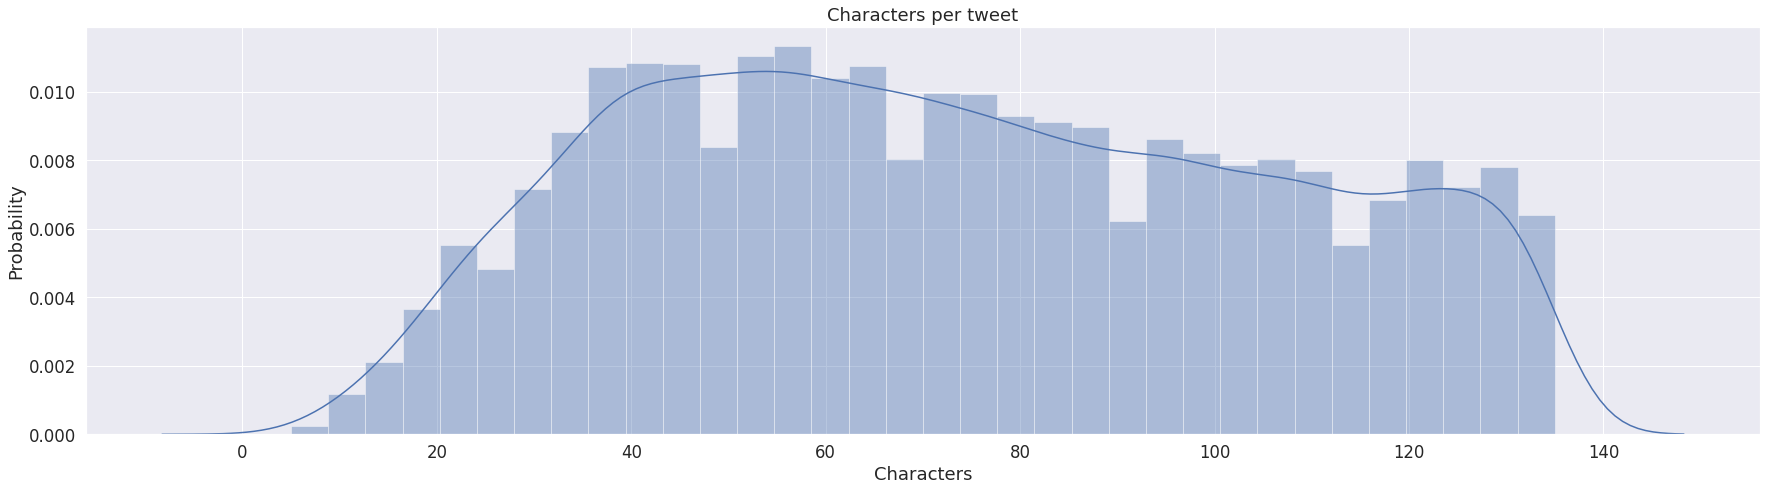

In [3]:
"""
Visualize the distribution of the number of characters per tweet
"""

sns.set(font_scale=1.5)
plt.figure(figsize=(30, 7.5))
fig = sns.distplot(sorted(train_df.tweet.apply(len))[:21000], color='b')
fig.set(title='Characters per tweet', xlabel='Characters', ylabel='Probability')
plt.show('--------------------------------------------------------------------')

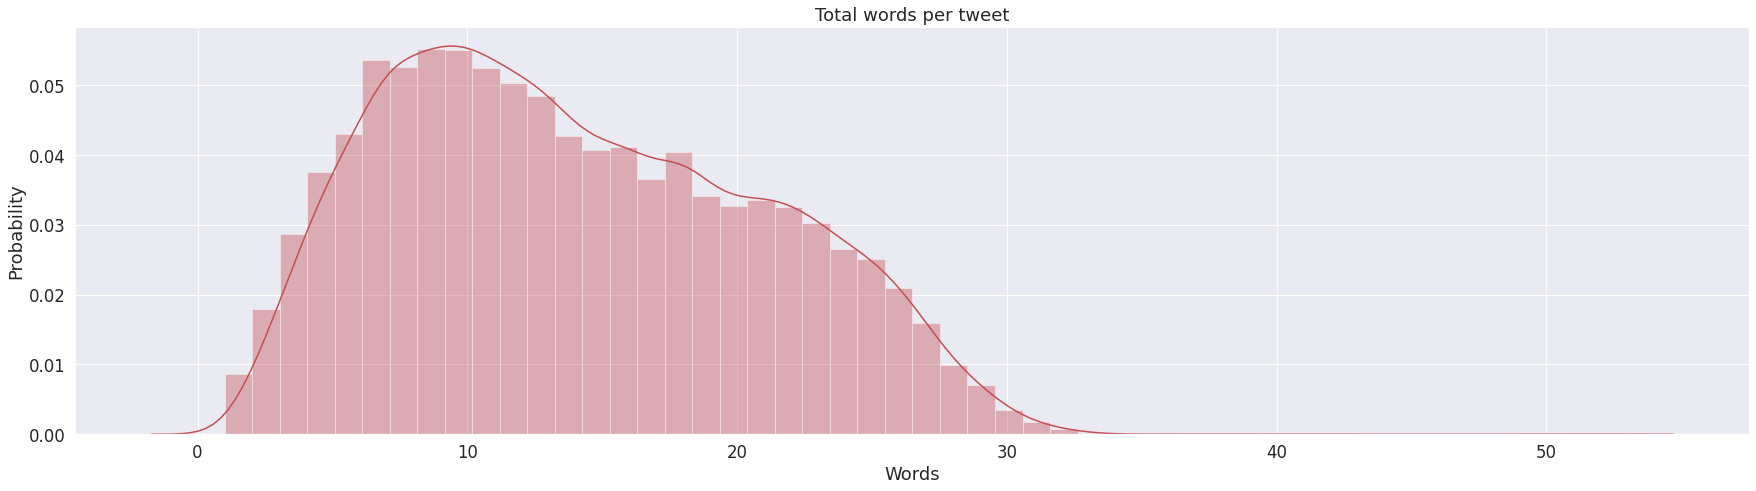

In [4]:
"""
Visualize the distribution of the number of words per tweet
"""

sns.set(font_scale=1.5)
plt.figure(figsize=(30, 7.5))
words = lambda x: len(x.split())
fig = sns.distplot(sorted(train_df.tweet.apply(words)), color='r')
fig.set(title='Total words per tweet', xlabel='Words', ylabel='Probability')
plt.show('----------------------------------------------------------------')

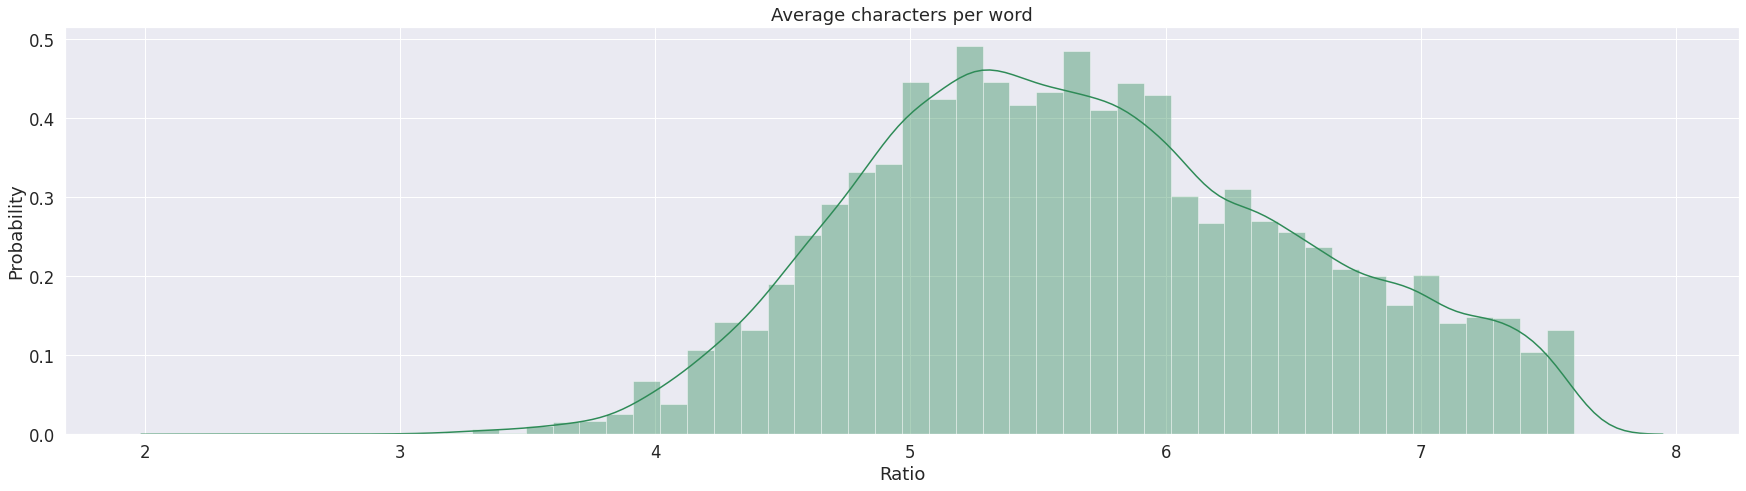

In [5]:
"""
Visualize the distribution of the number of characters per word
"""

sns.set(font_scale=1.5)
plt.figure(figsize=(30, 7.5))
ratio = lambda x: len(x)/len(x.split())
fig = sns.distplot(sorted(train_df.tweet.apply(ratio))[:21000], color='seagreen')
fig.set(title='Average characters per word', xlabel='Ratio', ylabel='Probability')
plt.show('----------------------------------------------------------------------')

In [6]:
train_df['label'].sum() / len(train_df['label']) * 100 # pecentage of bad tweets

83.20219505306056

In [7]:
sentences = train_df['tweet'].values
labels = train_df['label'].values

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=1000)

#build bag of words encoding for training data
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

model = LogisticRegression(max_iter = 5)
model.fit(X_train, labels_train)
print(model.score(X_train, labels_train) * 100)
print(model.score(X_test, labels_test) * 100)

89.39271663472208
88.1783336695582


In [8]:
hub_url = 'https://tfhub.dev/tensorflow/'
hub_id = 'bert_en_uncased_L-24_H-1024_A-16/1'
bert_layer = hub.KerasLayer(hub_url + hub_id, trainable = True)

In [9]:
# preprocessing data

do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

#Define the tokenizer to convert tweets into token vectors
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
tokenizer.tokenize("This is a sentence")

['this', 'is', 'a', 'sentence']

In [10]:
# tokenize sequence and truncate it
def tokenize_sequence(text, tokenizer, max_length):
  sequence = tokenizer.tokenize(text)
  true_size = max_length - 2
  sequence = sequence[:true_size]
  sequence.insert(0, '[CLS]')
  sequence.append('[SEP]')

  return sequence

In [11]:
text = "Make sure your function works correctly here!"
max_length = 7

print(tokenize_sequence(text, tokenizer, max_length))

['[CLS]', 'make', 'sure', 'your', 'function', 'works', '[SEP]']


In [12]:
def get_input_tokens(text, tokenizer, max_length):
  sequence = tokenize_sequence(text, tokenizer, max_length)

  seq_length = len(sequence)
  pad_length = max_length - seq_length
  input_ids = tokenizer.convert_tokens_to_ids(sequence)

  return sequence, input_ids, seq_length, pad_length

In [13]:
sample_tweet = "You can replace this with any string!"
sequence, input_tokens, seq_length, pad_length = get_input_tokens(sample_tweet, tokenizer, len(sample_tweet)+2)
for a, b in zip(sequence, input_tokens):
  print(str(a) + '\t' + str(b))

[CLS]	101
you	2017
can	2064
replace	5672
this	2023
with	2007
any	2151
string	5164
!	999
[SEP]	102


In [14]:
# get encodings and masks for all tweets
def bert_encode(texts, tokenizer, max_length=32):
    all_masks, all_tokens = [], []
    
    for text in tqdm(texts):
        sequence, input_tokens, seq_length, pad_length = get_input_tokens(text, tokenizer, max_length)

        # pad the sequences and add the attention masks 
        # (to pay attention to the relevant tokens in the tweet)
        input_tokens += [0] * pad_length
        input_pad_masks = [1] * seq_length + [0] * pad_length
        all_tokens = all_tokens + [input_tokens]
        all_masks = all_masks + [input_pad_masks]
    
    return np.array(all_tokens), np.array(all_masks), np.zeros_like(all_tokens)

In [15]:
# train model
train_labels = train_df.label.values.reshape(-1, 1)
train_input = bert_encode(train_df['tweet'], tokenizer, max_length = 32)

  0%|          | 0/24783 [00:00<?, ?it/s]

In [16]:
# Build a text classification model with a BERT backbone

def build_bert_model(bert_layer, max_len):
    word_ids = Input(shape=(max_len,), dtype=tf.int32)
    input_mask = Input(shape=(max_len,), dtype=tf.int32)
    segment_ids = Input(shape=(max_len,), dtype=tf.int32)
    _, bert_sequence_output = bert_layer([word_ids, input_mask, segment_ids])

    clf_output = bert_sequence_output[:, 0, :]
    output_layer = Dense(1, activation='sigmoid')
    output = output_layer(clf_output)
    return Model(inputs=[word_ids, input_mask, segment_ids], outputs=output)

In [17]:
model = build_bert_model(bert_layer, max_len = 32)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(1e-5), metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_1[0][0]',                
                                 (None, 32, 1024)]                'input_2[0][0]',            

In [18]:
train_history = model.fit(train_input, train_labels, 
                          epochs = 2, 
                          validation_split = 0.2, 
                          batch_size = 64, shuffle = False)

Epoch 1/2
310/310 [==============================] - 479s 1s/step - loss: 0.1958 - accuracy: 0.9162 - val_loss: 0.1208 - val_accuracy: 0.9510
Epoch 2/2
310/310 [==============================] - 446s 1s/step - loss: 0.0917 - accuracy: 0.9631 - val_loss: 0.1274 - val_accuracy: 0.9536


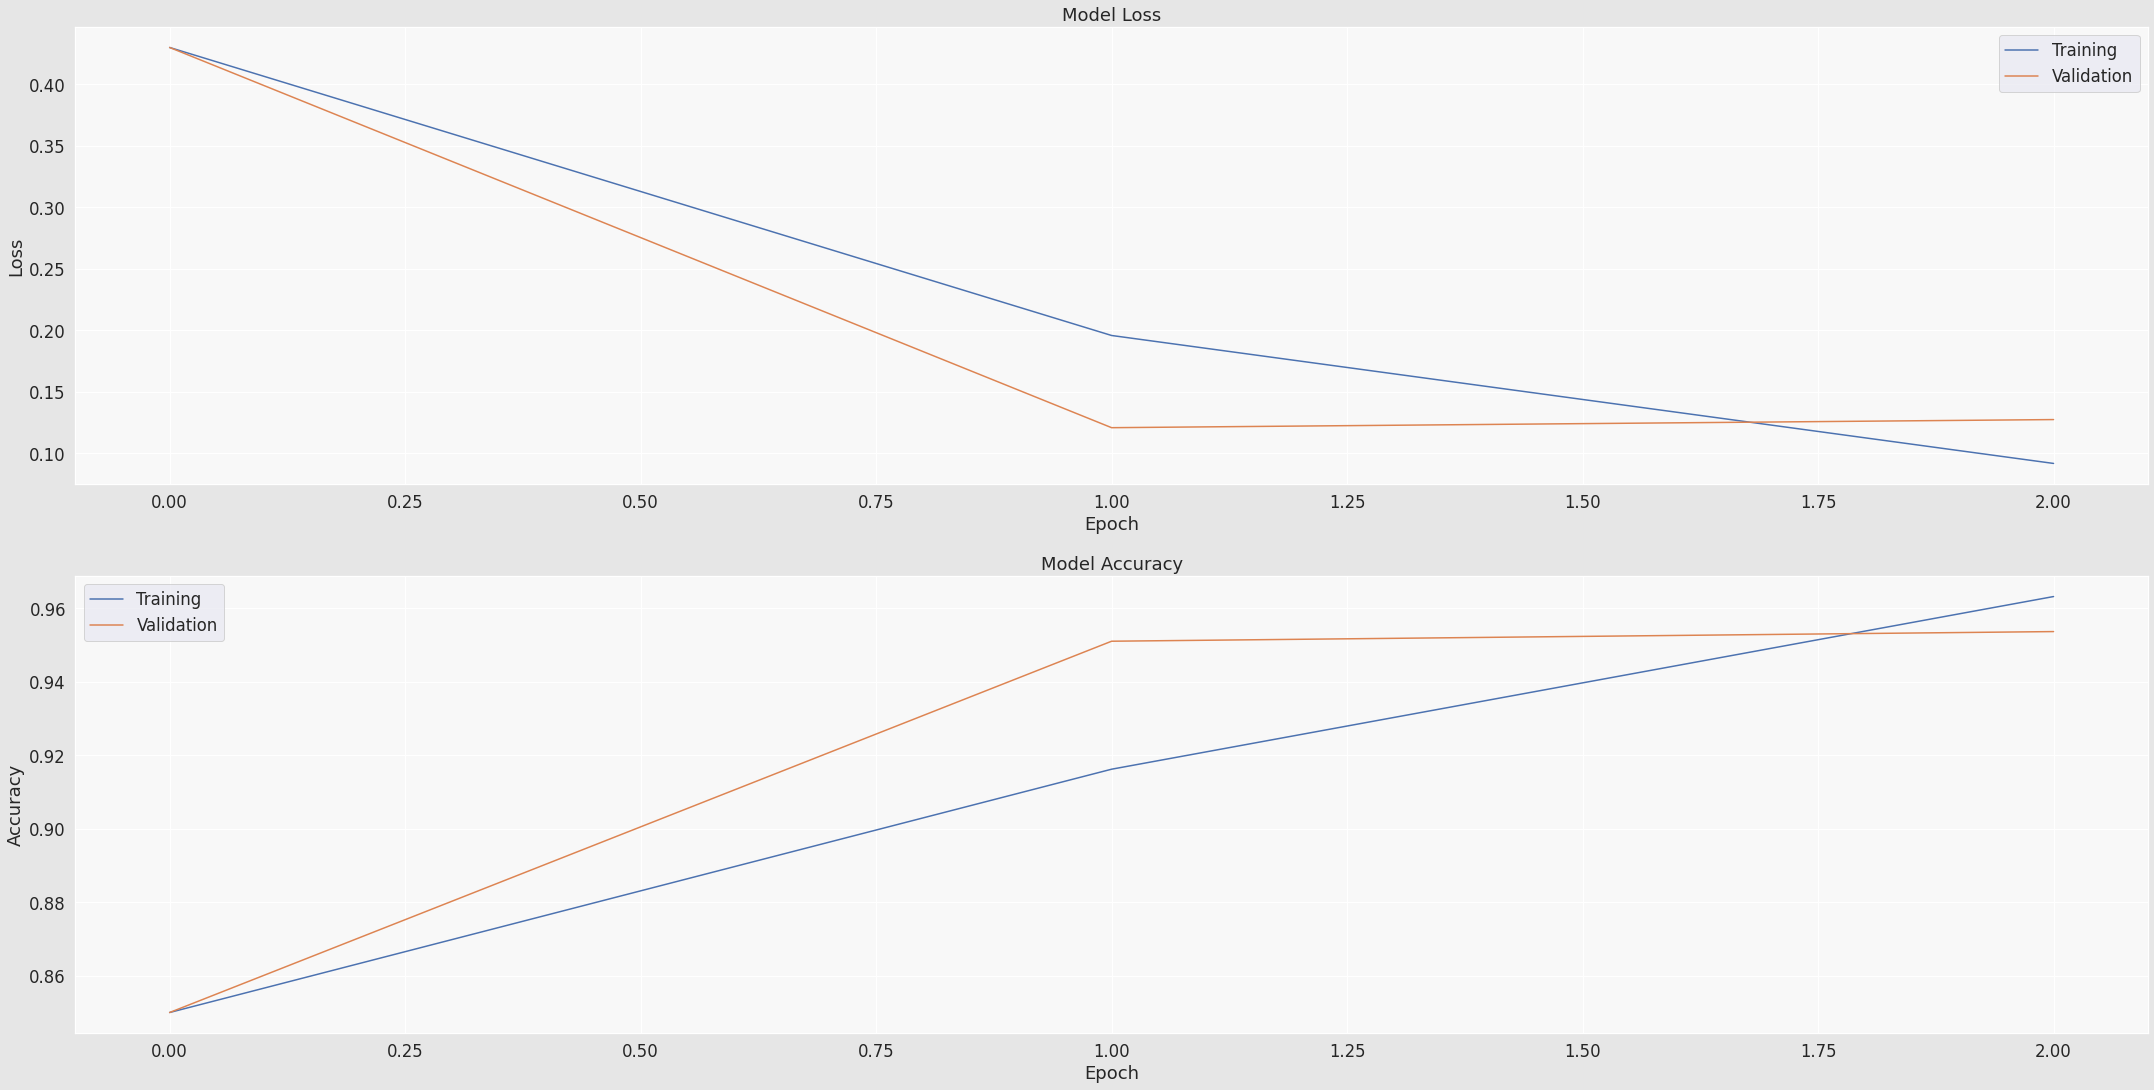

In [19]:
# visualize model performance
display_training_curves([0.43] + train_history.history['loss'], [0.43] + train_history.history['val_loss'], 'Loss', 211)
display_training_curves([0.85] + train_history.history['accuracy'], [0.85] + train_history.history['val_accuracy'], 'Accuracy', 212)

In [20]:
# general testing
prediction = bert_encode("You're stupid", tokenizer, max_length = 32)
prediction

  0%|          | 0/13 [00:00<?, ?it/s]

(array([[ 101, 1061,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 1051,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 1057,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 1005,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 1054,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0, 